 ! pip install psycopg2 

In [1]:
! pip install psycopg2

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import psycopg2
import psycopg2.extras 
import seaborn as sns
from matplotlib import pyplot as plt

### Создадим функцию для запроса данных о регистрации из БД. Создадим датафреймы с датой регистрации и количеством регистраций в мае и июне.

In [3]:
may = ['2019-05-01', '2019-06-01']
june = ['2019-06-01', '2019-07-01']
def getRegisteredUsersCount(start, end):
    query = f'''SELECT r.registration_date, count(distinct(r.user_id)) as registered_users_count
    FROM case9.registration r
    WHERE r.registration_date >= '{start}' and r.registration_date < '{end}'
    GROUP BY 1
    '''
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

registered_users_count_may = pd.DataFrame(getRegisteredUsersCount(may[0],may[1]))
registered_users_count_june = pd.DataFrame(getRegisteredUsersCount(june[0],june[1]))

Text(0.5, 1.0, 'Зарегистрировавшиеся в мае')

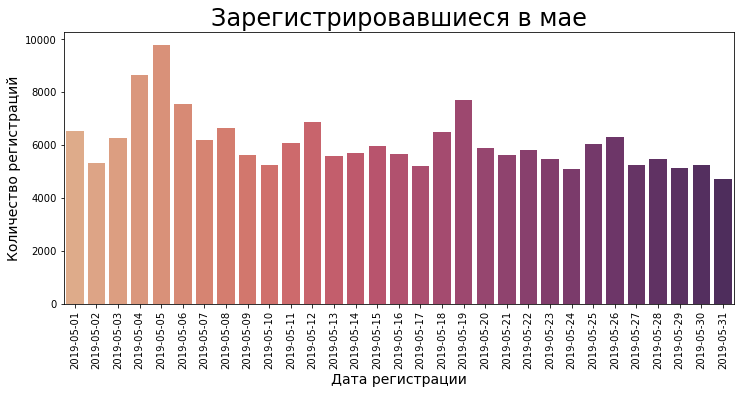

In [4]:
plt.figure(figsize=(12,5))
ax1 = sns.barplot(x="registration_date", y="registered_users_count", data=registered_users_count_may,
                 palette="flare")
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel("Количество регистраций", size = 14)
ax1.set_xlabel("Дата регистрации", size = 14)
ax1.set_title('Зарегистрировавшиеся в мае', size = 24)

Text(0.5, 1.0, 'Зарегистрировавшиеся в июне')

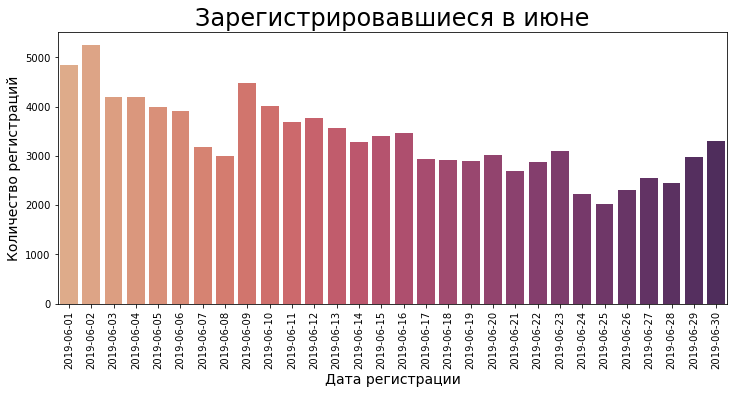

In [5]:
plt.figure(figsize=(12,5))
ax2 = sns.barplot(x="registration_date", y="registered_users_count", data=registered_users_count_june,
                 palette="flare")
ax2.tick_params(axis='x', rotation=90)
ax2.set_ylabel("Количество регистраций", size = 14)
ax2.set_xlabel("Дата регистрации", size = 14)
ax2.set_title('Зарегистрировавшиеся в июне', size = 24)

### Приведем в порядок даты в наших датафреймах и выведем общее число регистраций в мае и июне.

In [6]:
registered_users_count_may['registration_date'] = pd.to_datetime(registered_users_count_may['registration_date'])
registered_users_count_june['registration_date'] = pd.to_datetime(registered_users_count_june['registration_date'])

In [7]:
print('Всего в мае зарегистрировалось', registered_users_count_may['registered_users_count'].sum(), 'пользователей')
print('Всего в июне зарегистрировалось', registered_users_count_june['registered_users_count'].sum(), 'пользователей')
part = registered_users_count_june['registered_users_count'].sum()/registered_users_count_may['registered_users_count'].sum()
print('В июне было на', "{:.2%}".format(1-part), 'меньше регистраций чем в мае')

Всего в мае зарегистрировалось 188943 пользователей
Всего в июне зарегистрировалось 100423 пользователей
В июне было на 46.85% меньше регистраций чем в мае


### Запросим данные по активностям пользователей в разные дни и сопоставим их с датами регистрации для получения когорт. Проверим получившиеся датафреймы на пропуски в данных.

In [8]:
def getActiveUsersCountWithCohorts(start, end):
    query = f'''SELECT ac.activity_date, r.registration_date, count(distinct(ac.user_id)) as active_users_count
    FROM case9.user_activity ac
    LEFT JOIN case9.registration r ON r.user_id = ac.user_id
    WHERE r.registration_date >= '{start}' and r.registration_date < '{end}'
    GROUP BY 1,2
    '''
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

active_users_count_with_cohorts_may = pd.DataFrame(getActiveUsersCountWithCohorts(may[0],may[1]))
active_users_count_with_cohorts_june = pd.DataFrame(getActiveUsersCountWithCohorts(june[0],june[1]))
for col in ['activity_date','registration_date']:
    active_users_count_with_cohorts_may[col] = pd.to_datetime(active_users_count_with_cohorts_may[col])
    active_users_count_with_cohorts_june[col] = pd.to_datetime(active_users_count_with_cohorts_june[col])

In [9]:
active_users_count_with_cohorts_may.info()
active_users_count_with_cohorts_june.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   activity_date       961 non-null    datetime64[ns]
 1   registration_date   961 non-null    datetime64[ns]
 2   active_users_count  961 non-null    int64         
dtypes: datetime64[ns](2), int64(1)
memory usage: 22.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   activity_date       930 non-null    datetime64[ns]
 1   registration_date   930 non-null    datetime64[ns]
 2   active_users_count  930 non-null    int64         
dtypes: datetime64[ns](2), int64(1)
memory usage: 21.9 KB


### Объединим таблицы с количеством регистраций пользователей и количеством активных пользователей для подсчета Retention Rate.

In [10]:
print('Май')
retention_table_may = active_users_count_with_cohorts_may.merge(registered_users_count_may,on=['registration_date'],how='left')
retention_table_may['retention_rate'] = retention_table_may['active_users_count'] / retention_table_may['registered_users_count']
retention_table_may.head()

Май


,activity_date,registration_date,active_users_count,registered_users_count,retention_rate
0,2019-05-01,2019-05-01,2590,6516,0.397483
1,2019-05-02,2019-05-01,2146,6516,0.329343
2,2019-05-02,2019-05-02,2049,5309,0.385948
3,2019-05-03,2019-05-01,1637,6516,0.251228
4,2019-05-03,2019-05-02,1817,5309,0.342249


In [11]:
print('Июнь')
retention_table_june = active_users_count_with_cohorts_june.merge(registered_users_count_june,on=['registration_date'],how='left')
retention_table_june['retention_rate'] = retention_table_june['active_users_count'] / retention_table_june['registered_users_count']
retention_table_june.head()

Июнь


,activity_date,registration_date,active_users_count,registered_users_count,retention_rate
0,2019-06-01,2019-06-01,1651,4833,0.341610
1,2019-06-02,2019-06-01,1429,4833,0.295676
2,2019-06-02,2019-06-02,1933,5255,0.367840
3,2019-06-03,2019-06-01,1021,4833,0.211256
4,2019-06-03,2019-06-02,1550,5255,0.294957


### Для формирования сводной таблицы по когортам добавим в таблицы номер дня, считая от даты регистрации.

In [12]:
retention_table_may['lifetime'] = retention_table_may['activity_date'] - retention_table_may['registration_date']
retention_table_may['lifetime'] = retention_table_may['lifetime']/np.timedelta64(1,'D')
retention_table_may['lifetime'] = retention_table_may['lifetime'].astype(int)
retention_table_june['lifetime'] = retention_table_june['activity_date'] - retention_table_june['registration_date']
retention_table_june['lifetime'] = retention_table_june['lifetime']/np.timedelta64(1,'D')
retention_table_june['lifetime'] = retention_table_june['lifetime'].astype(int)
retention_table_june.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime
0,2019-06-01,2019-06-01,1651,4833,0.341610,0
1,2019-06-02,2019-06-01,1429,4833,0.295676,1
2,2019-06-02,2019-06-02,1933,5255,0.367840,0
3,2019-06-03,2019-06-01,1021,4833,0.211256,2
4,2019-06-03,2019-06-02,1550,5255,0.294957,1


### Сформируем сводные таблицы для мая и июня. Человеку их сложно воспринимать, поэтому добавим вывод в виде тепловой карты.

In [13]:
retention_pivot_may = retention_table_may.pivot_table(index='registration_date',columns='lifetime',values='retention_rate',aggfunc='sum')
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
retention_pivot_may

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
registration_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-05-01,0.397483,0.329343,0.251228,0.222683,0.198895,0.174954,0.153929,0.146255,0.133671,0.123082,0.115869,0.113260,0.106200,0.098834,0.096378,0.090393,0.086556,0.084408,0.084715,0.078729,0.077348,0.072284,0.069828,0.068754,0.067219,0.067373,0.063536,0.062922,0.060773,0.043738,0.029619
2019-05-02,0.385948,0.342249,0.254285,0.219062,0.193633,0.164061,0.152006,0.140328,0.125071,0.117160,0.111320,0.102844,0.098512,0.095875,0.089094,0.084762,0.076662,0.079111,0.075344,0.074779,0.069128,0.067056,0.059522,0.059898,0.061217,0.060652,0.058768,0.055943,0.053682,0.045018,0.031456
2019-05-03,0.381264,0.339291,0.256783,0.219438,0.188477,0.170124,0.148899,0.142834,0.132301,0.126716,0.112033,0.106288,0.101660,0.100383,0.091765,0.085701,0.086020,0.087297,0.082668,0.078040,0.075327,0.071976,0.070859,0.072455,0.069103,0.067028,0.066550,0.063837,0.060166,0.046920,0.030961
2019-05-04,0.384651,0.335224,0.241232,0.191573,0.169348,0.150249,0.140178,0.137284,0.131728,0.116796,0.109040,0.102790,0.096770,0.093877,0.094224,0.092256,0.086121,0.081259,0.078829,0.075124,0.074198,0.072925,0.071420,0.066906,0.065401,0.064012,0.061465,0.058456,0.057646,0.043176,0.029286
2019-05-05,0.383161,0.311944,0.227751,0.192398,0.170737,0.152549,0.145397,0.138755,0.121488,0.113518,0.106468,0.100439,0.094411,0.088689,0.090835,0.083682,0.079800,0.076734,0.075100,0.070808,0.068765,0.067641,0.063962,0.061101,0.060693,0.058547,0.057014,0.053438,0.054256,0.043936,0.027179
2019-05-06,0.368205,0.312260,0.227748,0.191377,0.162809,0.147732,0.137680,0.130274,0.117445,0.105806,0.098929,0.089406,0.086496,0.083851,0.082397,0.079751,0.073932,0.068642,0.067055,0.065864,0.064409,0.065997,0.062029,0.060045,0.055680,0.053829,0.050919,0.049597,0.048142,0.035048,0.021690
2019-05-07,0.366349,0.326020,0.239393,0.206808,0.172770,0.153251,0.142926,0.137280,0.124859,0.113405,0.105501,0.097758,0.090176,0.093241,0.092757,0.084046,0.080174,0.075173,0.071786,0.067753,0.070818,0.070657,0.062591,0.063559,0.060816,0.058235,0.057106,0.057590,0.055815,0.041781,0.028392
2019-05-08,0.393985,0.328271,0.245564,0.198195,0.176241,0.156692,0.142707,0.132782,0.121353,0.110977,0.101203,0.094887,0.091729,0.086767,0.083158,0.078797,0.076090,0.076090,0.071128,0.069774,0.069173,0.066316,0.063910,0.058195,0.056842,0.053534,0.053835,0.052632,0.048872,0.038496,0.026617
2019-05-09,0.377529,0.320909,0.236777,0.205183,0.180866,0.163649,0.147497,0.136138,0.124068,0.113774,0.107916,0.104011,0.097799,0.091232,0.085197,0.085907,0.082002,0.076855,0.074192,0.074547,0.072595,0.067093,0.066205,0.061945,0.060703,0.058218,0.055201,0.053958,0.054846,0.045971,0.029464


In [14]:
retention_pivot_june = retention_table_june.pivot_table(index='registration_date',columns='lifetime',values='retention_rate',aggfunc='sum')
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
retention_pivot_june

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
registration_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-06-01,0.341610,0.295676,0.211256,0.175667,0.143596,0.134906,0.121664,0.112766,0.110904,0.099938,0.095179,0.087523,0.082764,0.079247,0.078212,0.073453,0.070970,0.066625,0.064763,0.062487,0.064556,0.060418,0.061246,0.058763,0.055245,0.056487,0.050693,0.049659,0.050693,0.042003,0.028968
2019-06-02,0.367840,0.294957,0.221313,0.188202,0.164225,0.145576,0.130923,0.129971,0.121598,0.109610,0.103711,0.090771,0.091912,0.089629,0.089439,0.082778,0.081066,0.078021,0.076879,0.075167,0.070790,0.073073,0.071931,0.068506,0.062797,0.061656,0.062797,0.063178,0.060514,0.044719,0.028925
2019-06-03,0.341522,0.296685,0.207727,0.173384,0.150727,0.123062,0.118054,0.115430,0.111376,0.099213,0.093966,0.086096,0.084903,0.077510,0.080611,0.076795,0.076318,0.072979,0.067016,0.067016,0.067016,0.065109,0.064870,0.063916,0.057238,0.056284,0.051753,0.052707,0.051991,0.041975,0.028858
2019-06-04,0.351216,0.296853,0.229852,0.180019,0.147592,0.133047,0.135670,0.121841,0.106581,0.098236,0.090129,0.087744,0.079876,0.085122,0.080114,0.074154,0.067716,0.064855,0.065331,0.063186,0.064855,0.063662,0.060324,0.058417,0.053648,0.051502,0.051979,0.051264,0.047926,0.036242,0.023605
2019-06-05,0.337419,0.305403,0.223112,0.172336,0.147324,0.140570,0.131816,0.118059,0.108304,0.097799,0.094297,0.089045,0.087794,0.086043,0.084042,0.075288,0.075038,0.070285,0.069035,0.069785,0.069535,0.066033,0.064282,0.060030,0.056278,0.054527,0.054527,0.053527,0.051026,0.037519,0.027514
2019-06-06,0.362845,0.306551,0.208802,0.178864,0.169396,0.141505,0.131013,0.117707,0.109519,0.098516,0.096213,0.092375,0.090072,0.090072,0.085722,0.079324,0.072671,0.071904,0.074463,0.069857,0.066018,0.066018,0.063715,0.064483,0.057318,0.056551,0.055015,0.055527,0.055271,0.045803,0.030194
2019-06-07,0.370719,0.294691,0.219290,0.190386,0.171222,0.147345,0.129752,0.120955,0.108702,0.106189,0.102105,0.093937,0.093622,0.089224,0.090481,0.083883,0.080741,0.080741,0.078856,0.075401,0.073830,0.068803,0.068803,0.068175,0.068175,0.063776,0.064719,0.062834,0.059692,0.045240,0.027961
2019-06-08,0.361902,0.330097,0.251423,0.204553,0.179444,0.156344,0.144961,0.141948,0.127218,0.116170,0.110479,0.104118,0.102444,0.098761,0.091731,0.089722,0.092066,0.085370,0.085035,0.081353,0.082022,0.076666,0.071979,0.072648,0.071979,0.067626,0.066622,0.066622,0.065618,0.052896,0.037496
2019-06-09,0.363961,0.321811,0.234835,0.192685,0.165923,0.149643,0.143845,0.136039,0.118198,0.113069,0.106824,0.102141,0.098573,0.098796,0.097235,0.090321,0.087868,0.085415,0.081178,0.076494,0.076494,0.081401,0.074710,0.071142,0.066905,0.068020,0.065343,0.066236,0.062444,0.049286,0.031891


Text(0.5, 66.5, 'День после регистрации')

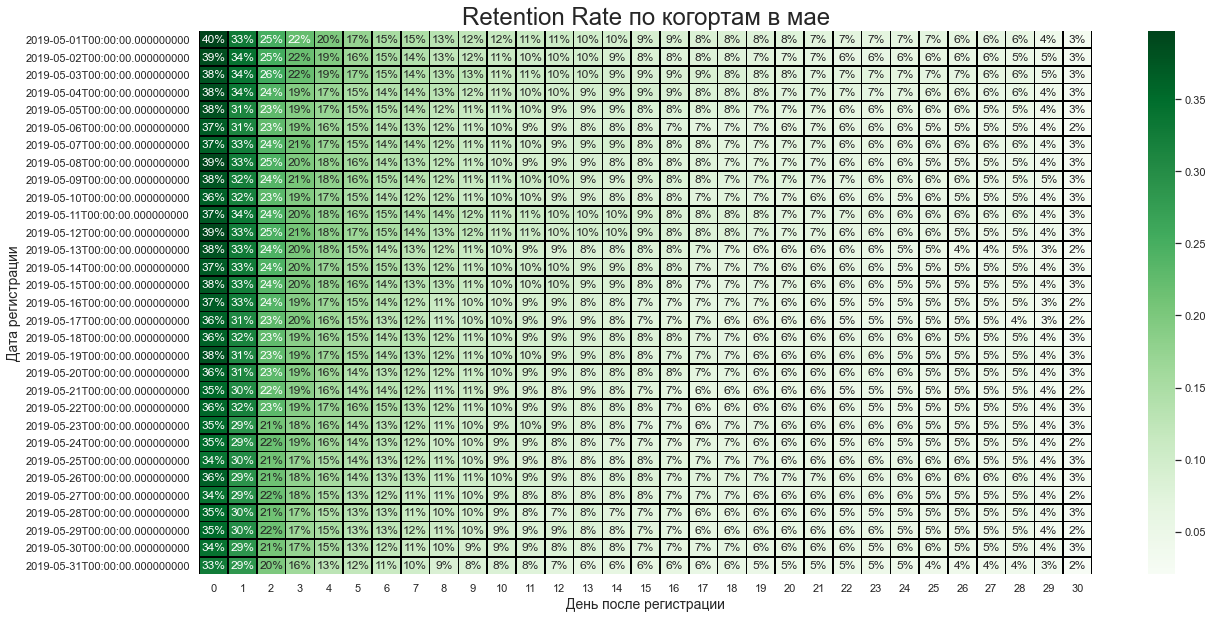

In [15]:
sns.set(style='white')
plt.figure(figsize=(20, 10))
plt.title('Retention Rate по когортам в мае', size=24)
ax = sns.heatmap(retention_pivot_may, mask=retention_pivot_may.isnull(), annot=True, fmt='.0%', linewidths=0.5, linecolor='black', cmap="Greens")
ax.set_ylabel("Дата регистрации", size = 14)
ax.set_xlabel("День после регистрации", size = 14)

Text(0.5, 66.5, 'День после регистрации')

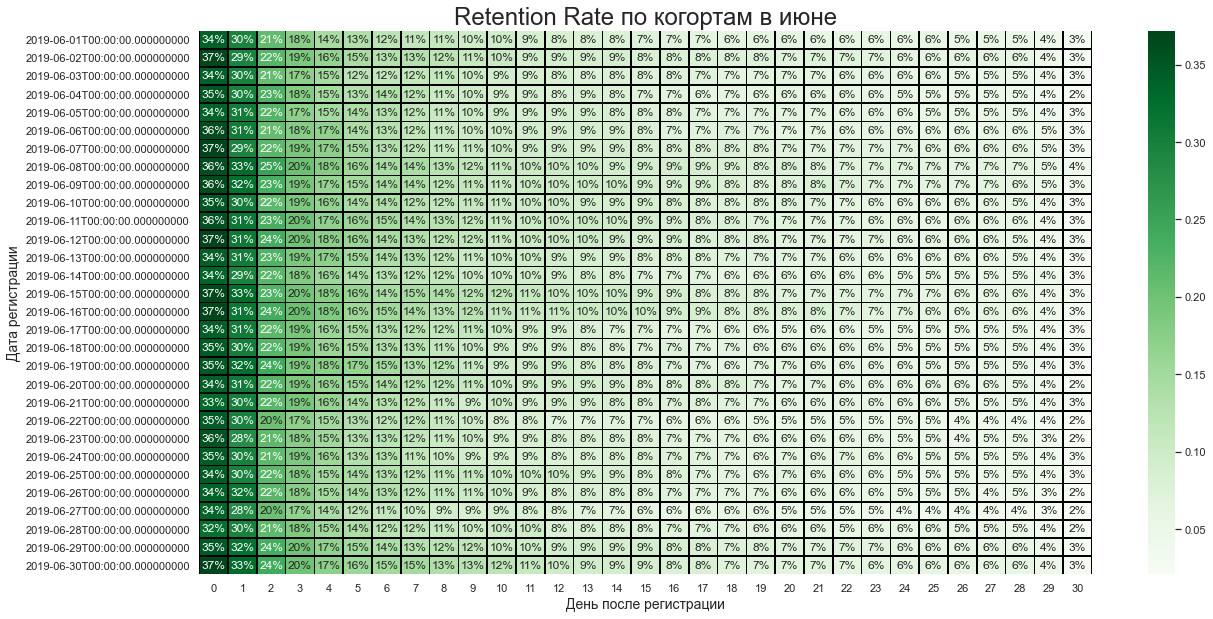

In [16]:
sns.set(style='white')
plt.figure(figsize=(20, 10))
plt.title('Retention Rate по когортам в июне', size=24)
ax=sns.heatmap(retention_pivot_june, mask=retention_pivot_june.isnull(), annot=True, fmt='.0%', linewidths=0.5, linecolor='black', cmap="Greens")
ax.set_ylabel("Дата регистрации", size = 14)
ax.set_xlabel("День после регистрации", size = 14)

### Посмотрим на диаграмму Retention Rate на 7 день.

Text(0.5, 1.0, 'Retention Rate на 7 день в мае')

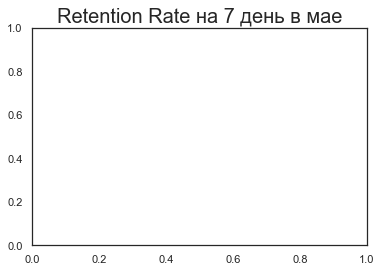

In [17]:
plt.title('Retention Rate на 7 день в мае', size=20)

<AxesSubplot:title={'center':'Retention Rate на 7 день в июне'}, xlabel='registration_date'>

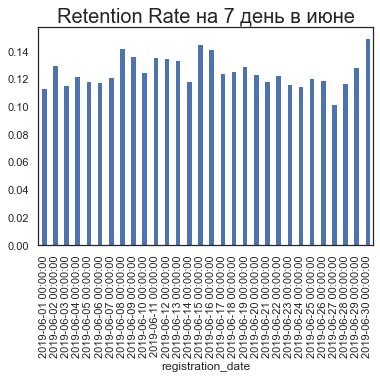

In [18]:
plt.title('Retention Rate на 7 день в июне', size=20)
retention_pivot_june[7].plot.bar()

### Наглядно видно, что в мае к концу месяца Retention Rate снижается, а в июне наоборот повышается. Проверим это на числах.

In [19]:
print('Retention Rate когорты в конце месяца относительно когорты начала месяца в мае уменьшился на', "{:.2%}".format(1-retention_pivot_may[7]['2019-05-31']/retention_pivot_may[7]['2019-05-01']))

Retention Rate когорты в конце месяца относительно когорты начала месяца в мае уменьшился на 31.11%


In [20]:
print('Retention Rate когорты в конце месяца относительно когорты начала месяца в июне вырос на', "{:.2%}".format(retention_pivot_june[7]['2019-06-30']/retention_pivot_june[7]['2019-06-01']-1))

Retention Rate когорты в конце месяца относительно когорты начала месяца в июне вырос на 32.44%


### Retention Rate в июне показал положительную динамику в отличие от мая: +32% против -31%.

### Запросим данные по выручке и создадим датафреймы для мая и июня. Датафреймы будут включать дату платежа, дату регистрации, количество заплативших пользователей и сумму платежей.

In [21]:
def getRevenue(start, end):
    query = f'''SELECT re.date, r.registration_date, count(distinct(re.user_id)) as users_count_with_revenue, sum(re.revenue) as revenue
    FROM case9.user_revenue re
    LEFT JOIN case9.registration r ON r.user_id = re.user_id
    WHERE r.registration_date >= '{start}' and r.registration_date < '{end}'
    GROUP BY 1,2
    '''
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

revenue_may = pd.DataFrame(getRevenue(may[0],may[1]))
revenue_june = pd.DataFrame(getRevenue(june[0],june[1]))

In [22]:
revenue_may.info()
revenue_june.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      912 non-null    object 
 1   registration_date         912 non-null    object 
 2   users_count_with_revenue  912 non-null    int64  
 3   revenue                   912 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 28.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833 entries, 0 to 832
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      833 non-null    object 
 1   registration_date         833 non-null    object 
 2   users_count_with_revenue  833 non-null    int64  
 3   revenue                   833 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 26.2+ KB


In [23]:
for col in ['date','registration_date']:
    revenue_may[col] = pd.to_datetime(revenue_may[col])
    revenue_june[col] = pd.to_datetime(revenue_june[col])
    
revenue_may = revenue_may.rename(columns={'date':'activity_date'})
revenue_june = revenue_june.rename(columns={'date':'activity_date'})

In [24]:
revenue_june.head()

,activity_date,registration_date,users_count_with_revenue,revenue
0,2019-06-01,2019-06-01,1082,1611.860
1,2019-06-02,2019-06-01,928,317.738
2,2019-06-02,2019-06-02,1257,1305.220
3,2019-06-03,2019-06-01,623,192.273
4,2019-06-03,2019-06-02,1008,554.859


### Посмоторим на сумму выручки в мае и июне.

In [25]:
print("Сумма выручки в мае:", "{:.4f}".format(revenue_may['revenue'].sum()))
print("Сумма выручки в июне:", "{:.4f}".format(revenue_june['revenue'].sum()))

Сумма выручки в мае: 121998.2986
Сумма выручки в июне: 79685.8654


### Сумма выручки в мае больше, однако, мы помним, что число регистраций в июне было меньше на 46%. Посмотрим, что с выручкой на одну регистрацию.

In [26]:
rpu_may=revenue_may['revenue'].sum()/registered_users_count_may['registered_users_count'].sum()
rpu_june=revenue_june['revenue'].sum()/registered_users_count_june['registered_users_count'].sum()
print("Revenue per registered user в мае:", "{:.4f}".format(rpu_may))
print("Revenue per registered user в июне:", "{:.4f}".format(rpu_june))
print("Revenue per registered user в июне выше на","{:.2%}".format(1-rpu_may/rpu_june), "чем в мае")

Revenue per registered user в мае: 0.6457
Revenue per registered user в июне: 0.7935
Revenue per registered user в июне выше на 18.63% чем в мае


### Видим, что Revenue per registered user в июне выше на 18.63% чем в мае. Однако считать выручку на зарегистрировшегося пользователя не очень показательно - стоит посмотреть выручку по активным и платящим пользователям.

### Рассчитаем показатели ARPU и ARPPU.

In [27]:
# Уберем пробелы в данных.
retention_table_with_revenue_may = retention_table_may.merge(revenue_may,on=['registration_date','activity_date'],how='left')
retention_table_with_revenue_june = retention_table_june.merge(revenue_june,on=['registration_date','activity_date'],how='left')
for col in ['revenue','users_count_with_revenue']:
    retention_table_with_revenue_may[col] = retention_table_with_revenue_may[col].fillna(0)
    retention_table_with_revenue_june[col] = retention_table_with_revenue_june[col].fillna(0)
retention_table_with_revenue_may['users_count_with_revenue'] = retention_table_with_revenue_may['users_count_with_revenue'].astype(int)
retention_table_with_revenue_june['users_count_with_revenue'] = retention_table_with_revenue_june['users_count_with_revenue'].astype(int)

In [28]:
retention_table_with_revenue_may['arppu'] = retention_table_with_revenue_may['revenue']/retention_table_with_revenue_may['users_count_with_revenue']
retention_table_with_revenue_june['arppu'] = retention_table_with_revenue_june['revenue']/retention_table_with_revenue_june['users_count_with_revenue']

In [29]:
retention_table_with_revenue_june['arpu'] = retention_table_with_revenue_june['revenue']/retention_table_with_revenue_june['active_users_count']
retention_table_with_revenue_may['arpu'] = retention_table_with_revenue_may['revenue']/retention_table_with_revenue_may['active_users_count']

In [30]:
retention_table_with_revenue_june.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime,users_count_with_revenue,revenue,arppu,arpu
0,2019-06-01,2019-06-01,1651,4833,0.341610,0,1082,1611.860,1.489704,0.976293
1,2019-06-02,2019-06-01,1429,4833,0.295676,1,928,317.738,0.342390,0.222350
2,2019-06-02,2019-06-02,1933,5255,0.367840,0,1257,1305.220,1.038361,0.675230
3,2019-06-03,2019-06-01,1021,4833,0.211256,2,623,192.273,0.308624,0.188318
4,2019-06-03,2019-06-02,1550,5255,0.294957,1,1008,554.859,0.550455,0.357974


### Построим тепловые карты ARPPU по месяцам.

Text(0.5, 66.5, 'День после регистрации')

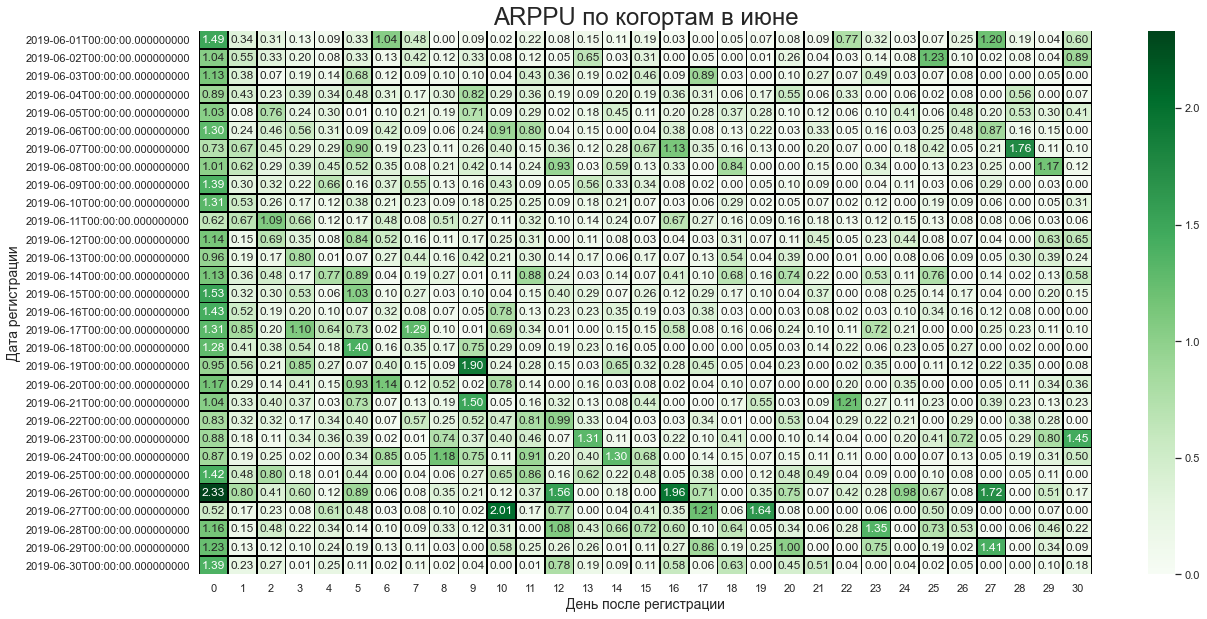

In [31]:
retention_pivot_with_rev_june = retention_table_with_revenue_june.pivot_table(index='registration_date',columns='lifetime',values='arppu',aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(20, 10))
plt.title('ARPPU по когортам в июне', size=24)
ax=sns.heatmap(retention_pivot_with_rev_june, mask=retention_pivot_with_rev_june.isnull(), annot=True, fmt='.2f', linewidths=0.5, linecolor='black', cmap="Greens")
ax.set_ylabel("Дата регистрации", size = 14)
ax.set_xlabel("День после регистрации", size = 14)

<AxesSubplot:xlabel='registration_date'>

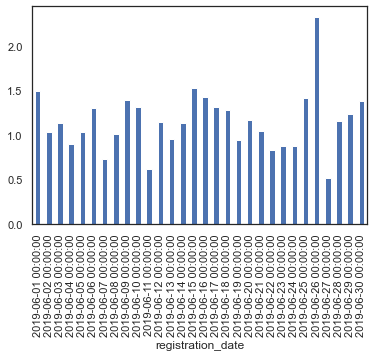

In [32]:
retention_pivot_with_rev_june[0].plot.bar()

Text(0.5, 66.5, 'День после регистрации')

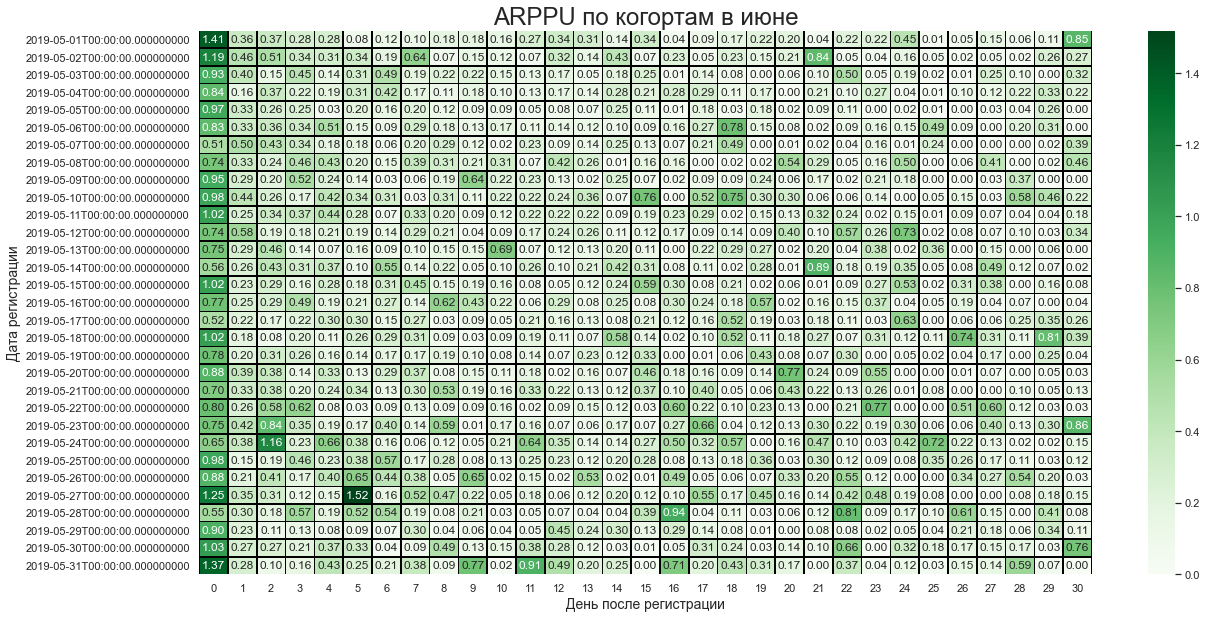

In [33]:
retention_pivot_with_rev_may = retention_table_with_revenue_may.pivot_table(index='registration_date',columns='lifetime',values='arppu',aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(20, 10))
plt.title('ARPPU по когортам в июне', size=24)
ax=sns.heatmap(retention_pivot_with_rev_may, mask=retention_pivot_with_rev_may.isnull(), annot=True, fmt='.2f', linewidths=0.5, linecolor='black', cmap="Greens")
ax.set_ylabel("Дата регистрации", size = 14)
ax.set_xlabel("День после регистрации", size = 14)

<AxesSubplot:xlabel='registration_date'>

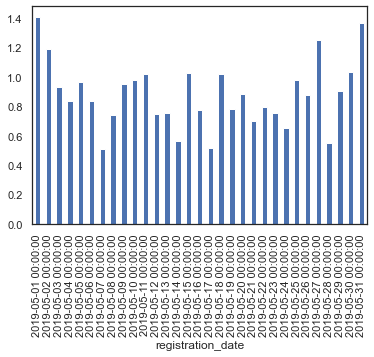

In [34]:
retention_pivot_with_rev_may[0].plot.bar()

### Каких либо сильных изменений на глаз не заметно. Сравним ARPPU в день регистрации в мае и в июне.

In [35]:
print("Средняя ARPPU в день регистрации в мае:", "{:.4f}".format(retention_pivot_with_rev_may[0].mean()))
print("Средняя ARPPU в день регистрации в июне:", "{:.4f}".format(retention_pivot_with_rev_june[0].mean()))
print("Средняя ARPPU в день регистрации в июне выше на","{:.2%}".format(1-retention_pivot_with_rev_may[0].mean()/retention_pivot_with_rev_june[0].mean()), "чем в мае")

Средняя ARPPU в день регистрации в мае: 0.8805
Средняя ARPPU в день регистрации в июне: 1.1504
Средняя ARPPU в день регистрации в июне выше на 23.46% чем в мае


## Общие выводы:
## 1. Внедрении фичи позволило повысить Retention Rate: если в мае было снижение на 31% от начала к концу месяца, то в июне мы наоборот увидели увеличение на 32%.
## 2. Также фича повлияла на ARPPU: средняя ARPPU в день регистрации в июне выше на 23.46% чем в мае
## Получается, что фича положительно повлияла на продуктовые метрики, можем продолжать ее тестирование дальше.